# Spotify Project - Jeremias Figueroa

*** This is a working document.

*** Next steps include more analytics on the data itself, clustering the songs together based off different characteristics, and performing regressions to see if different characteristics affect popularity or not.

## Imports

First, install spotipy using the following in a code cell:

Or to upgrade use the following in a code cell:

Next, install gspread using the following in a code cell:

Now import the following as well:

In [1]:
#to access spotipy
import configparser
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth

#to parse through spotipy's output
import json

#to access google sheets with python
import gspread
from google.oauth2 import service_account

#for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

#to measure performance
import time

#for machine learning purposes
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Spotify API Client Credientials

First ensure that you have a Spotify For Developers account.

Then, using https://developer.spotify.com/dashboard/applications, make an new app and get client ID and client secret ID

In [2]:
#use your own client ID and client secret ID

client_credentials_manager = SpotifyClientCredentials(client_id="your client ID", client_secret="your secret ID")

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)



## Importing Google Sheet

Use song information from the following Google Sheet: https://docs.google.com/spreadsheets/d/165OdLYjLt4AgeqP5S5PunRonDkpp28nueHLFv994bPk/edit?usp=sharing

This Google Sheet is a collection of hit songs from HITS Daily Double, a music industry trade publication, and their weekly Overall Song Streams chart. The data includes how many times a song was streamed week-to-week for most weeks since 2017 (with the exception of holiday weeks, weeks when holiday music regularly push out non-holiday songs out of the top spots of music charts). 

In order to be able to use this data on your own device, create a copy to your own Drive. Follow the instructions in the following: https://github.com/PrettyPrinted/youtube_video_code/tree/master/2021/10/14/How%20to%20Use%20Google%20Sheets%20With%20Python%20(2021)

In [3]:
#service account
sa = gspread.service_account()

#sheet
sh = sa.open("HITS Streaming Songs")

#worksheet
wks = sh.worksheet("HITS Streaming Songs")

#uses all values in the worksheet for the data frame
gsheets_df = pd.DataFrame(wks.get_all_values())

header = gsheets_df.iloc[0] #isolate first row as header
gsheets_df = gsheets_df[1:] #get rid of header in original df
gsheets_df.columns = header

#set 'song_id' as index
gsheets_df = gsheets_df.set_index('index')

gsheets_df['title'] = gsheets_df['title'].str.rstrip(' ')
gsheets_df['artist'] = gsheets_df['artist'].str.rstrip(' ')
gsheets_df['album'] = gsheets_df['album'].str.rstrip(' ')

#convert index from string to int
gsheets_df.index = gsheets_df.index.astype(int)

#fill in blank values with 0
gsheets_df = gsheets_df.replace(r'^\s*$', "0", regex=True)

#convert all numbers-as-strings to numbers from row 4 in python's index and onwards
for col_name in gsheets_df.columns.to_list()[4:len(gsheets_df.columns.to_list())]:
    
    #get rid of strings' commas and convert strings to integers
    gsheets_df[col_name] = gsheets_df[col_name].str.replace(',','').astype('int')
    
#turn peak_date strings to date format
gsheets_df['peak_date'] = pd.to_datetime(gsheets_df['peak_date'])

gsheets_df


,title,artist,album,peak_date,streams_2017_to_present,total_streams_2020s,peak_week_streams,2022-03-11,2022-03-04,2022-02-25,...,2017-04-28,2017-04-21,2017-04-14,2017-04-07,2017-03-31,,total_2022,total_2021,total_2020,units
index,,,,,,,,,,,,,,,,,,,,,
586,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,Hollywood's Bleeding,2019-01-11,1239204097,327815689,28799621,0,5619585,0,...,0,0,0,0,0,0,33292311,36229466,258293912,239997
1032,Blinding Lights,The Weeknd,After Hours,2020-03-20,1077467797,1039272066,29444746,0,5860521,5745609,...,0,0,0,0,0,0,30707499,353815051,654749516,245373
750,Old Town Road - Remix,Lil Nas X,7 EP,2019-04-05,977389701,23153286,83196801,0,0,0,...,0,0,0,0,0,0,0,0,23153286,693307
1034,The Box,Roddy Ricch,Please Excuse Me for Being Antisocial,2020-01-17,890033461,840988925,57151149,0,0,0,...,0,0,0,0,0,0,0,11538330,829450595,476260
240,God's Plan,Drake,Scorpion,2018-01-19,825137204,0,73364601,0,0,0,...,0,0,0,0,0,0,0,0,0,611372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,Doves In The Wind (feat. Kendrick Lamar),SZA,Ctrl,2017-06-09,5089362,0,5089362,0,0,0,...,0,0,0,0,0,0,0,0,0,42411
76,Sweet Creature,Harry Styles,Harry Styles,2017-05-12,5054041,0,5054041,0,0,0,...,0,0,0,0,0,0,0,0,0,42117
91,Rain On Me (Intro),Bryson Tiller,True to Self,2017-05-26,5023856,0,5023856,0,0,0,...,0,0,0,0,0,0,0,0,0,41865


## Get song URIs from Spotipy 

When searching up a song on Spotify, numerous versions of the same song can be returned. For purposes of this analysis, songs are taken from the explicit version of their parent album/single/EP, regardless of whether the song itself is explicit or clean. If no explicit version of the parent album/single/EP exists, the original version (which would be clean) is to be used. 

In order to utilize Spotify's API for the desired songs (from the Google Sheet), URIs must be retrieved using the following functions:

In [4]:
"""
Returns track URI and explicit status for a song

:param data: a song within the dataframe of all HIT songs (series)
"""

def search_for_URI(data):
    song_to_search = data['title']
    album_to_search = data['album']
    song_and_artist = song_to_search + " " + data['artist']
    
    #this function searches for q on Spotify
    result = sp.search(q=song_and_artist)
    
    #to store all non-instrumental versions of a song
    dct_of_versions = {}
    
    #loops through all results from search
    for song_info_index in range(len(result['tracks']['items'])):

        #checks for results' album to match the input data's album title
        if (result['tracks']['items'][song_info_index]['album']['name'].replace("’","").replace("'","").lower() == album_to_search.replace("’","").replace("'","").lower()):
                        
            #checks for results' song title to match input data's song title
            if (result['tracks']['items'][song_info_index]['name'].replace("’","").replace("'","").lower() == song_to_search.replace("’","").replace("'","").lower()):     
                
                #empty lists of all non-instrumental versions of a song
                explicit_song_list = []
                clean_song_from_original_album_list = []
                clean_song_from_clean_album_list = []

                #if a song isn't explicit
                if result['tracks']['items'][song_info_index]['explicit'] == False:
                    
                    #checks if clean song from original album is not in our dct_of_verions
                    if 'clean_song_from_original_album_list' not in dct_of_versions:
                        clean_song_from_original_album_list.append(result['tracks']['items'][song_info_index]['name'])
                        clean_song_from_original_album_list.append(result['tracks']['items'][song_info_index]['artists'][0]['name'])
                        clean_song_from_original_album_list.append(result['tracks']['items'][song_info_index]['album']['name'])
                        clean_song_from_original_album_list.append(result['tracks']['items'][song_info_index]['explicit'])
                        clean_song_from_original_album_list.append(result['tracks']['items'][song_info_index]['uri'])
                        dct_of_versions['clean_song_from_original_album_list'] = clean_song_from_original_album_list
                        
                    #if clean song from original album is in dct_of_versions
                    else:
                        clean_song_from_clean_album_list.append(result['tracks']['items'][song_info_index]['name'])
                        clean_song_from_clean_album_list.append(result['tracks']['items'][song_info_index]['artists'][0]['name'])
                        clean_song_from_clean_album_list.append(result['tracks']['items'][song_info_index]['album']['name'])
                        clean_song_from_clean_album_list.append(result['tracks']['items'][song_info_index]['explicit'])
                        clean_song_from_clean_album_list.append(result['tracks']['items'][song_info_index]['uri'])
                        dct_of_versions['clean_song_from_clean_album_list'] = clean_song_from_clean_album_list
                        
                #checks if a song is explicit       
                if result['tracks']['items'][song_info_index]['explicit'] == True:
                        
                    explicit_song_list.append(result['tracks']['items'][song_info_index]['name'])
                    explicit_song_list.append(result['tracks']['items'][song_info_index]['artists'][0]['name'])
                    explicit_song_list.append(result['tracks']['items'][song_info_index]['album']['name'])
                    explicit_song_list.append(result['tracks']['items'][song_info_index]['explicit'])
                    explicit_song_list.append(result['tracks']['items'][song_info_index]['uri'])
                    dct_of_versions['explicit_song_list'] = explicit_song_list
    
    if 'explicit_song_list' in dct_of_versions:
        return dct_of_versions['explicit_song_list']
                        
    elif 'clean_song_from_original_album_list' in dct_of_versions:
        return dct_of_versions['clean_song_from_original_album_list']
    else:
        return [song_to_search,data['artist'],album_to_search,"",""]


The following code takes a while to perform as it uses the function defined above to look up information for ~2000 songs. To measure performance, a timer feature is utilized.

In [5]:
#create a list of song info: song title, artist, album, explicit or not, track URI

#start timer
start = time.process_time()

song_list = []
[song_list.append(search_for_URI(gsheets_df.loc[song_info_index+1,'title':'album'])) for song_info_index in range(len(gsheets_df.loc[:]))]

#print time
print(time.process_time() - start)

23.817098


In [6]:
#convert list to DataFrame
uri_df = pd.DataFrame(song_list,columns=["song","artist","album","explicit","uri"])

#change index to start at 1
uri_df.index = range(1,len(uri_df)+1)
uri_df

,song,artist,album,explicit,uri
1,The One,The Chainsmokers,Memories...Do Not Open,True,spotify:track:0wfbD5rAksdXUzRvMfM3x5
2,Sacrifices,Drake,More Life,True,spotify:track:0xl1w2q4VLojeXp4JfazPL
3,Closer,The Chainsmokers,Closer,False,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw
4,Starboy,The Weeknd,Starboy,True,spotify:track:7MXVkk9YMctZqd1Srtv4MB
5,Get It Together,Drake,More Life,True,spotify:track:7y6c07pgjZvtHI9kuMVqk1
...,...,...,...,...,...
2001,Smoking & Thinking,Lil Durk,7220,True,spotify:track:0pAAZgDYZYJZnVqpoWylvr
2002,Grow Up/Keep It On Speaker,Lil Durk,7220,True,spotify:track:6n6vizDAhZI6Qg52pgslRl
2003,Blocklist,Lil Durk,7220,True,spotify:track:7l0xKufZFhZ10JDvIJypA6
2004,Difference Is (feat. Summer Walker),Lil Durk,7220,True,spotify:track:0IWQIEINYabd6XRCPQM1TT


In [7]:
#check for any songs that don't have URIs
data_to_clean = uri_df[uri_df['uri'] == ""]
data_to_clean.index = range(1,len(data_to_clean)+1)
data_to_clean

data_to_clean[:]

,song,artist,album,explicit,uri
1,"SORRY NOT SORRY (feat. Nas, JAY-Z & James Faun...",DJ Khaled,KHALED KHALED,,
2,NOT SOBER (feat. Polo G & Stunna Gambino),The Kid LAROI,F*CK LOVE 3+: OVER YOU,,


The search-for-URI function worked with a 99.8+% success rate! 

For the songs that didn't get a URI, individually check what searching it on Spotify's API would result in using the following function. 

From there, get the URI for the desired song/version of a song, manually enter it into uri_df, and update and check the data_to_clean dataframe created above until there is nothing left in data_to_clean. 

In [8]:
"""
If a song doesn't have URI, individually check what searching it in Spotify's API would result in

Use your browser to look up a URI to double-check you get your desired version of a song
"""

#change q to adjust for your desired song search
result = sp.search(q="NOT SOBER     The Kid LAROI ")
for song_info_dict in range(len(result['tracks']['items'])):
    print(result['tracks']['items'][song_info_dict]['name'])
    print(result['tracks']['items'][song_info_dict]['artists'][0]['name'])
    print(result['tracks']['items'][song_info_dict]['album']['name'])
    print(result['tracks']['items'][song_info_dict]['explicit'])
    print(result['tracks']['items'][song_info_dict]['uri'],"\n")


NOT SOBER (feat. Polo G & Stunna Gambino)
The Kid LAROI
F*CK LOVE 3: OVER YOU
True
spotify:track:1JXBNvlDEl2epKSJ9EOgKX 

STAY (with Justin Bieber)
The Kid LAROI
STAY (with Justin Bieber)
True
spotify:track:5HCyWlXZPP0y6Gqq8TgA20 

NOT SOBER (feat. Polo G & Stunna Gambino)
The Kid LAROI
F*CK LOVE 3+: OVER YOU
True
spotify:track:29t9XYOV65fFXiVzFFJgHH 

Hate The Other Side (with Marshmello & The Kid Laroi)
Juice WRLD
Legends Never Die
True
spotify:track:0ada5XsQGLPUVbmTCkAP49 

NOT SOBER (feat. Polo G & Stunna Gambino)
The Kid LAROI
F*CK LOVE 3+: OVER YOU
False
spotify:track:2bFqWhULDfCMc2tlr39hOX 

STAY (with Justin Bieber)
The Kid LAROI
F*CK LOVE 3: OVER YOU
True
spotify:track:5PjdY0CKGZdEuoNab3yDmX 

WITHOUT YOU
The Kid LAROI
F*CK LOVE (SAVAGE)
True
spotify:track:27OeeYzk6klgBh83TSvGMA 

GO (feat. Juice WRLD)
The Kid LAROI
F*CK LOVE
True
spotify:track:2rPHUAeUPbNgTmK18FPTiZ 

Costa Rica (feat. The Kid LAROI) - Remix
Bankrol Hayden
Pain is Temporary
True
spotify:track:3tdjTdCCgKtwacsI

In [9]:
"""
manually adding the URIs
"""

#fixing data from Not Sober by The Kid LAROI 
uri_df.loc[1710]['explicit'] = True
uri_df.loc[1710]['uri'] = "spotify:track:29t9XYOV65fFXiVzFFJgHH"

#update and check data_to_clean using the code below this cell

#fixing data from Sorry Not Sorry by DJ Khaled
uri_df.loc[1599]['explicit'] = True
uri_df.loc[1599]['uri'] = "spotify:track:5OypcrFg58e4k2iYHi69ED"
#update and check data_to_clean using the code below this cell

In [10]:
#run to update and check data_to_clean
data_to_clean = uri_df[uri_df['uri'] == ""]
data_to_clean.index = range(1,len(data_to_clean)+1)
data_to_clean
data_to_clean[:]

#repeat this and update uri's manually until data_to_clean is empty

,song,artist,album,explicit,uri


In [11]:
#check final uri_df with all URIs
uri_df

,song,artist,album,explicit,uri
1,The One,The Chainsmokers,Memories...Do Not Open,True,spotify:track:0wfbD5rAksdXUzRvMfM3x5
2,Sacrifices,Drake,More Life,True,spotify:track:0xl1w2q4VLojeXp4JfazPL
3,Closer,The Chainsmokers,Closer,False,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw
4,Starboy,The Weeknd,Starboy,True,spotify:track:7MXVkk9YMctZqd1Srtv4MB
5,Get It Together,Drake,More Life,True,spotify:track:7y6c07pgjZvtHI9kuMVqk1
...,...,...,...,...,...
2001,Smoking & Thinking,Lil Durk,7220,True,spotify:track:0pAAZgDYZYJZnVqpoWylvr
2002,Grow Up/Keep It On Speaker,Lil Durk,7220,True,spotify:track:6n6vizDAhZI6Qg52pgslRl
2003,Blocklist,Lil Durk,7220,True,spotify:track:7l0xKufZFhZ10JDvIJypA6
2004,Difference Is (feat. Summer Walker),Lil Durk,7220,True,spotify:track:0IWQIEINYabd6XRCPQM1TT


## Get spotipy's API information

Spotify has a plethora of information on a song's characteristics. The following functions/cells create a dataframe with song characteristic information on each song from the Google Sheet.

In [12]:
"""
takes in a song's URI
returns information on a song's characteristics
"""
def getTrackFeatures(track_id):
    md = sp.track(track_id)
    features = sp.audio_features(track_id)
    
    #meta data
    name = md['name']
    album = md['album']['name']
    artist = md['album']['artists'][0]['name']
    release_date = md['album']['release_date']
    length = md['duration_ms']
    popularity = md['popularity']
    
    #features from the data
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    key = features[0]['key']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    mode = features[0]['mode']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']
    valence = features[0]['valence']
    
    #putting it all together
    track = [name, album, artist, release_date, length, popularity, 
             acousticness, danceability, energy, instrumentalness, key,
            liveness, loudness, mode, speechiness, 
             tempo, time_signature, valence]
    
    return track

Similar to a previous function, the following function takes a while to execute, as it looks up track features for ~2000 songs from Spotify's API. To measure performance, a timer is used. 

In [13]:
#Get track features for all tracks, append to a list

#start timer
start = time.process_time() 

tracks = []

[tracks.append( getTrackFeatures(uri_df['uri'][i]) ) for i in range(1,len(uri_df['uri'])+1)]

#print time
print(time.process_time() - start)

30.306752


In [14]:
#Convert list to DataFrame

api_info_df = pd.DataFrame(tracks,columns=['name','album','artist',
    'release_date','length','popularity','acousticness','danceability',
    'energy','instrumentalness','key','liveness','loudness','mode',
    'speechiness','tempo','time_signature','valence'])

#change index to start at one
api_info_df.index = range(1,len(api_info_df)+1)

#change release_date to date format
api_info_df['release_date'] = pd.to_datetime(api_info_df['release_date'])

api_info_df

,name,album,artist,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
1,The One,Memories...Do Not Open,The Chainsmokers,2017-04-07,177573,64,0.2380,0.760,0.303,0.000008,2,0.2940,-11.362,1,0.0284,99.991,4,0.150
2,Sacrifices,More Life,Drake,2017-03-18,307593,65,0.0407,0.903,0.439,0.000000,8,0.1380,-11.813,1,0.3970,139.112,4,0.532
3,Closer,Closer,The Chainsmokers,2016-07-29,244960,88,0.4140,0.748,0.524,0.000000,8,0.1110,-5.599,1,0.0338,95.010,4,0.661
4,Starboy,Starboy,The Weeknd,2016-11-25,230453,88,0.1410,0.679,0.587,0.000006,7,0.1370,-7.015,1,0.2760,186.003,4,0.486
5,Get It Together,More Life,Drake,2017-03-18,250337,74,0.0945,0.781,0.721,0.391000,5,0.1040,-9.133,0,0.0514,123.011,4,0.849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001,Smoking & Thinking,7220,Lil Durk,2022-03-18,147391,0,0.0169,0.842,0.512,0.000000,11,0.2020,-8.202,1,0.3330,162.023,4,0.688
2002,Grow Up/Keep It On Speaker,7220,Lil Durk,2022-03-18,196341,0,0.0276,0.512,0.633,0.000002,1,0.5780,-7.951,0,0.2890,113.621,3,0.236
2003,Blocklist,7220,Lil Durk,2022-03-18,126653,0,0.0615,0.621,0.572,0.000000,5,0.0890,-8.102,0,0.2180,83.694,4,0.208
2004,Difference Is (feat. Summer Walker),7220,Lil Durk,2022-03-18,193396,0,0.1250,0.488,0.482,0.000000,10,0.0999,-9.127,0,0.3820,158.669,3,0.318


## Joining all the data

Combine all the data collected/generated above!

In [15]:
#concatinate all variables into a final dataframe
final_df = pd.concat([gsheets_df.loc[:,'title':'album'],
                        uri_df.loc[:,'uri'] ,
                        gsheets_df.loc[:,'peak_date':'peak_week_streams'],
                      api_info_df.loc[:,'release_date':'valence'],
                      uri_df.loc[:,'explicit'],
                      gsheets_df.loc[:,'2022-02-25':'2017-03-31']
                      ],
                  axis=1)
final_df


,title,artist,album,uri,peak_date,streams_2017_to_present,total_streams_2020s,peak_week_streams,release_date,length,...,2017-06-02,2017-05-26,2017-05-19,2017-05-12,2017-05-05,2017-04-28,2017-04-21,2017-04-14,2017-04-07,2017-03-31
586,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,Hollywood's Bleeding,spotify:track:0RiRZpuVRbi7oqRdSMwhQY,2019-01-11,1239204097,327815689,28799621,2019-09-06,157560,...,0,0,0,0,0,0,0,0,0,0
1032,Blinding Lights,The Weeknd,After Hours,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,2020-03-20,1077467797,1039272066,29444746,2020-03-20,200040,...,0,0,0,0,0,0,0,0,0,0
750,Old Town Road - Remix,Lil Nas X,7 EP,spotify:track:2YpeDb67231RjR0MgVLzsG,2019-04-05,977389701,23153286,83196801,2019-06-21,157066,...,0,0,0,0,0,0,0,0,0,0
1034,The Box,Roddy Ricch,Please Excuse Me for Being Antisocial,spotify:track:0nbXyq5TXYPCO7pr3N8S4I,2020-01-17,890033461,840988925,57151149,2019-12-06,196652,...,0,0,0,0,0,0,0,0,0,0
240,God's Plan,Drake,Scorpion,spotify:track:6DCZcSspjsKoFjzjrWoCdn,2018-01-19,825137204,0,73364601,2018-06-29,198973,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,Doves In The Wind (feat. Kendrick Lamar),SZA,Ctrl,spotify:track:593W4qZOwwdqF6YnimJjL6,2017-06-09,5089362,0,5089362,2017-06-09,266080,...,0,0,0,0,0,0,0,0,0,0
76,Sweet Creature,Harry Styles,Harry Styles,spotify:track:5kRPPEWFJIMox5qIkQkiz5,2017-05-12,5054041,0,5054041,2017-05-12,224866,...,0,0,0,5054041,0,0,0,0,0,0
91,Rain On Me (Intro),Bryson Tiller,True to Self,spotify:track:52LjL3x9tNh6C4eI6SMceX,2017-05-26,5023856,0,5023856,2017-05-26,145120,...,0,5023856,0,0,0,0,0,0,0,0
170,Unforgettable,Thomas Rhett,Life Changes,spotify:track:30MM5jWpUmOxtTNd9Ey5LZ,2017-09-08,4995167,0,4995167,2017-09-08,157080,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#convert length (milliseconds) to min:sec:millisecond format
def ms_to_time(ms):
    millis = ms
    seconds=(millis/1000)%60
    seconds = int(seconds)
    minutes=(millis/(1000*60))%60
    minutes = int(minutes)
    
    #a string will be returned so add 0 before songs with length < 10 mins so that songs above 10 mins won't be misordered when ordering by min:sec:ms format
    if minutes < 10:
        return "0%d:%d:%d" % (minutes, seconds, millis)
    else:
        return "%d:%d:%d" % (minutes, seconds, millis)
    
#apply the function to final_df['length']
final_df['min_sec_mls'] = final_df['length'].apply(lambda x: ms_to_time(x))


## Data Analysis (Song Length)

In [17]:
#isolate peak years, months, and weeks
final_df['peak_year'] = final_df['peak_date'].apply(lambda x: x.year)
final_df['peak_month'] = final_df['peak_date'].apply(lambda x: x.month)
final_df['peak_week'] = final_df['peak_date'].apply(lambda x: x.isocalendar()[1])

#normalize tempos
final_df['tempo_normalized'] = final_df['tempo'] / final_df['tempo'].max()

#normalize lengths
final_df['length_normalized'] = final_df['length'] / final_df['length'].max()

In [18]:
final_df.sort_values('length')

,title,artist,album,uri,peak_date,streams_2017_to_present,total_streams_2020s,peak_week_streams,release_date,length,...,2017-04-21,2017-04-14,2017-04-07,2017-03-31,min_sec_mls,peak_year,peak_month,peak_week,tempo_normalized,length_normalized
1326,Juice WRLD Speaks From Heaven - Outro,Juice WRLD,Legends Never Die,spotify:track:1OjiYjgPZyxS0AiXiSnuYI,2020-07-10,9414576,9414576,9414576,2020-07-10,30582,...,0,0,0,0,00:30:30582,2020,7,28,0.586468,0.049887
505,raindrops (an angel cried),Ariana Grande,Sweetener,spotify:track:0v2LUO8oTHnkjQ8MmKuXyk,2018-08-17,6761327,0,6761327,2018-08-17,37640,...,0,0,0,0,00:37:37640,2018,8,33,0.813034,0.061400
1302,Bad Bitch From Tokyo (Intro),Pop Smoke,Shoot For The Stars Aim For The Moon,spotify:track:4OGIeHtYhRTJ8iW21UUyZW,2020-07-03,10488880,10488880,10488880,2020-07-03,48000,...,0,0,0,0,00:48:48000,2020,7,27,0.675972,0.078300
1006,Jesus Is Lord,Kanye West,JESUS IS KING,spotify:track:7sBgFMWqDWQgrsNSpIBoe8,2019-10-25,11326298,0,11326298,2019-10-25,49292,...,0,0,0,0,00:49:49292,2019,10,43,0.369248,0.080408
1763,Donda Chant,Kanye West,Donda,spotify:track:7eSSmgq26BXr7xay3WKjfi,2021-08-27,7803482,7803482,7803482,2021-08-29,52061,...,0,0,0,0,00:52:52061,2021,8,34,0.496361,0.084925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,FEAR.,Kendrick Lamar,DAMN.,spotify:track:23luOrEVHMfoX0AhfbQuS6,2017-04-14,16811902,0,16811902,2017-04-14,460573,...,0,16811902,0,0,07:40:460573,2017,4,15,0.724971,0.751311
1684,WILSHIRE,"Tyler, The Creator",CALL ME IF YOU GET LOST,spotify:track:1pbbsI2KGPOMu0HmuGccBu,2021-06-25,9945175,9945175,9945175,2021-06-25,515865,...,0,0,0,0,08:35:515865,2021,6,25,0.380564,0.841506
1759,Jesus Lord,Kanye West,Donda,spotify:track:1LwdWIbfuqlOo8vlHxkyna,2021-08-27,18908607,18908607,10204183,2021-08-29,538536,...,0,0,0,0,08:58:538536,2021,8,34,0.511563,0.878488
1688,SWEET / I THOUGHT YOU WANTED TO DANCE (feat. B...,"Tyler, The Creator",CALL ME IF YOU GET LOST,spotify:track:3EG9FJ0ToLfgnc1IG2Z1wz,2021-06-25,8465252,8465252,8465252,2021-06-25,588139,...,0,0,0,0,09:48:588139,2021,6,25,0.675852,0.959403


mean time for songs in the data set is: 03:20:200740
median time for songs in the data set is: 03:16:196946
2005 songs appeared on the HITS Streaming Chart since 2017


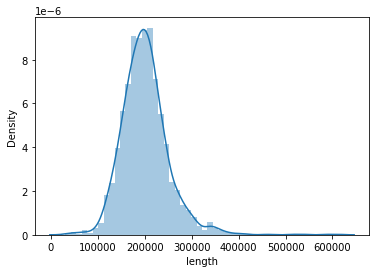

In [19]:
sns.distplot(final_df['length'])

print("mean time for songs in the data set is:", ms_to_time(final_df['length'].mean()))
print("median time for songs in the data set is:", ms_to_time(final_df['length'].median()))
print(len(final_df), "songs appeared on the HITS Streaming Chart since 2017")


Most songs seem to hover around the 3 minutes 20 seconds mark. 

This is remarkable because many articles in recent years reported hit songs decreasing in length in these last several years because of streaming. 

As a result the following dataframes isolates for songs that earned at a minimum threshold of streams while they were in the top 50 of the HITS streaming chart. 

mean time for songs with at least 50 mil streams during their time in the top 50 is: 03:21:201318
median time for songs with at least 50 mil streams during their time in the top 50 is: 03:19:199240
582 songs earned over 50 mil streams during their time in the top 50 since 2017


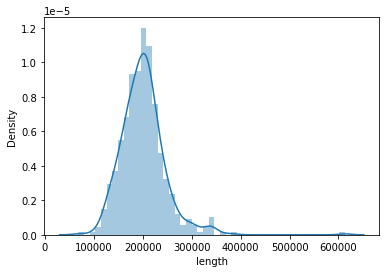

In [20]:
songs_over_50_mil = final_df[final_df['streams_2017_to_present'] > 50000000]
songs_over_50_mil.index = range(1,len(songs_over_50_mil)+1)
songs_over_50_mil

sns.distplot(songs_over_50_mil['length'])

print("mean time for songs with at least 50 mil streams during their time in the top 50 is:", ms_to_time(songs_over_50_mil['length'].mean()))
print("median time for songs with at least 50 mil streams during their time in the top 50 is:", ms_to_time(songs_over_50_mil['length'].median()))
print(len(songs_over_50_mil), "songs earned over 50 mil streams during their time in the top 50 since 2017")




mean time for songs with at least 100 mil streams during their time in the top 50 is: 03:20:200690
median time for songs with at least 100 mil streams during their time in the top 50 is: 03:20:200203
358 songs earned over 100 mil streams during their time in the top 50 since 2017


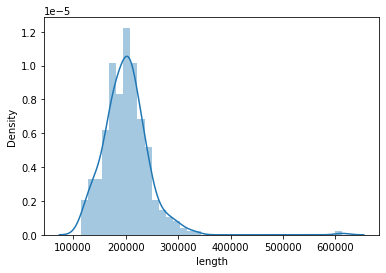

In [21]:
songs_over_100_mil = final_df[final_df['streams_2017_to_present'] > 100000000]
songs_over_100_mil.index = range(1,len(songs_over_100_mil)+1)
songs_over_100_mil

sns.distplot(songs_over_100_mil['length'])

print("mean time for songs with at least 100 mil streams during their time in the top 50 is:", ms_to_time(songs_over_100_mil['length'].mean()))
print("median time for songs with at least 100 mil streams during their time in the top 50 is:", ms_to_time(songs_over_100_mil['length'].median()))
print(len(songs_over_100_mil), "songs earned over 100 mil streams during their time in the top 50 since 2017")



mean time for songs with at least 200 mil streams during their time in the top 50 is: 03:17:197203
median time for songs with at least 200 mil streams during their time in the top 50 is: 03:15:195428
187 songs earned over 200 mil streams during their time in the top 50 since 2017


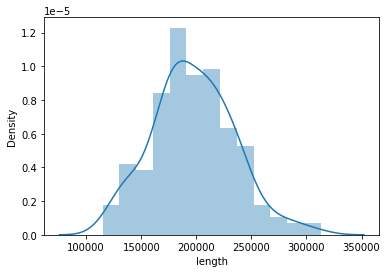

In [22]:
songs_over_200_mil = final_df[final_df['streams_2017_to_present'] > 200000000]
songs_over_200_mil.index = range(1,len(songs_over_200_mil)+1)
songs_over_200_mil

sns.distplot(songs_over_200_mil['length'])

print("mean time for songs with at least 200 mil streams during their time in the top 50 is:", ms_to_time(songs_over_200_mil['length'].mean()))
print("median time for songs with at least 200 mil streams during their time in the top 50 is:", ms_to_time(songs_over_200_mil['length'].median()))
print(len(songs_over_200_mil), "songs earned over 200 mil streams during their time in the top 50 since 2017")


mean time for songs with at least 300 mil streams during their time in the top 50 is: 03:20:200241
median time for songs with at least 300 mil streams during their time in the top 50 is: 03:21:201552
106 songs earned over 300 mil streams during their time in the top 50 since 2017


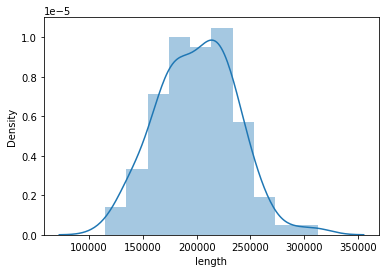

In [23]:
songs_over_300_mil = final_df[final_df['streams_2017_to_present'] > 300000000]
songs_over_300_mil.index = range(1,len(songs_over_300_mil)+1)
songs_over_300_mil

sns.distplot(songs_over_300_mil['length'])

print("mean time for songs with at least 300 mil streams during their time in the top 50 is:", ms_to_time(songs_over_300_mil['length'].mean()))
print("median time for songs with at least 300 mil streams during their time in the top 50 is:", ms_to_time(songs_over_300_mil['length'].median()))
print(len(songs_over_300_mil), "songs earned over 300 mil streams during their time in the top 50 since 2017")



mean time for songs with at least 400 mil streams during their time in the top 50 is: 03:16:196224
median time for songs with at least 400 mil streams during their time in the top 50 is: 03:16:196040
56 songs earned over 400 mil streams during their time in the top 50 since 2017


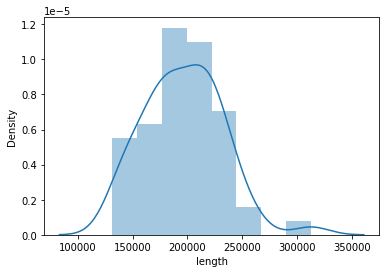

In [24]:
songs_over_400_mil = final_df[final_df['streams_2017_to_present'] > 400000000]
songs_over_400_mil.index = range(1,len(songs_over_400_mil)+1)
songs_over_400_mil

sns.distplot(songs_over_400_mil['length'])

print("mean time for songs with at least 400 mil streams during their time in the top 50 is:", ms_to_time(songs_over_400_mil['length'].mean()))
print("median time for songs with at least 400 mil streams during their time in the top 50 is:", ms_to_time(songs_over_400_mil['length'].median()))
print(len(songs_over_400_mil), "songs earned over 400 mil streams during their time in the top 50 since 2017")



mean time for songs with at least 500 mil streams during their time in the top 50 is: 03:19:199522
median time for songs with at least 500 mil streams during their time in the top 50 is: 03:19:199506
36 songs earned over 500 mil streams during their time in the top 50 since 2017


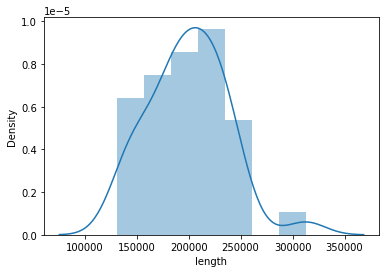

In [25]:
songs_over_500_mil = final_df[final_df['streams_2017_to_present'] > 500000000]
songs_over_500_mil.index = range(1,len(songs_over_500_mil)+1)
songs_over_500_mil

sns.distplot(songs_over_500_mil['length'])

print("mean time for songs with at least 500 mil streams during their time in the top 50 is:", ms_to_time(songs_over_500_mil['length'].mean()))
print("median time for songs with at least 500 mil streams during their time in the top 50 is:", ms_to_time(songs_over_500_mil['length'].median()))
print(len(songs_over_500_mil), "songs earned over 500 mil streams during their time in the top 50 since 2017")



mean time for songs with at least 600 mil streams during their time in the top 50 is: 03:28:208456
median time for songs with at least 600 mil streams during their time in the top 50 is: 03:21:201552
16 songs earned over 500 mil streams during their time in the top 50 since 2017


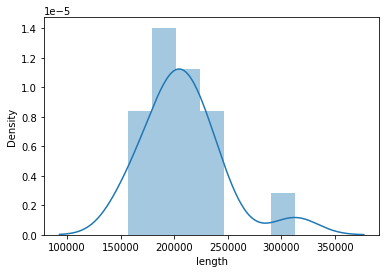

In [26]:
songs_over_600_mil = final_df[final_df['streams_2017_to_present'] > 600000000]
songs_over_600_mil.index = range(1,len(songs_over_600_mil)+1)
songs_over_600_mil

sns.distplot(songs_over_600_mil['length'])

print("mean time for songs with at least 600 mil streams during their time in the top 50 is:", ms_to_time(songs_over_600_mil['length'].mean()))
print("median time for songs with at least 600 mil streams during their time in the top 50 is:", ms_to_time(songs_over_600_mil['length'].median()))
print(len(songs_over_600_mil), "songs earned over 500 mil streams during their time in the top 50 since 2017")


Based on the analysis above, it seems like no matter how much we filter for how much a song was streamed while it was in the top 50, the mean and median time for a hit song still hovers around at 3:20. 

In [27]:
#group data by year/month with mean data
df_grpd_ym = final_df.groupby(['peak_year','peak_month']).mean().reset_index()
df_grpd_ym

,peak_year,peak_month,streams_2017_to_present,total_streams_2020s,peak_week_streams,length,popularity,acousticness,danceability,energy,...,2017-05-12,2017-05-05,2017-04-28,2017-04-21,2017-04-14,2017-04-07,2017-03-31,peak_week,tempo_normalized,length_normalized
0,2017,1,3.283118e+07,0.000000e+00,7.085109e+06,229888.058824,75.588235,0.172365,0.744294,0.618588,...,2.401335e+06,2.518441e+06,2.574150e+06,0.0,3.462409e+06,6.159888e+06,4.972690e+06,1.000000,0.578966,0.375005
1,2017,2,7.817144e+07,0.000000e+00,8.747127e+06,218045.000000,12.000000,0.660000,0.692000,0.220000,...,7.228668e+06,7.762262e+06,8.227998e+06,0.0,8.244591e+06,8.747127e+06,8.575615e+06,8.000000,0.482615,0.355686
2,2017,3,5.357339e+07,0.000000e+00,9.555294e+06,232293.533333,74.933333,0.105587,0.759133,0.518267,...,3.775640e+06,3.893395e+06,4.088558e+06,0.0,5.450607e+06,8.426619e+06,9.348220e+06,11.333333,0.625979,0.378929
3,2017,4,1.447942e+08,0.000000e+00,2.152991e+07,239202.571429,76.095238,0.167963,0.677714,0.579476,...,8.303257e+06,9.387156e+06,1.047852e+07,0.0,1.968746e+07,4.954428e+06,4.560054e+06,15.000000,0.626974,0.390200
4,2017,5,7.870167e+07,0.000000e+00,8.513141e+06,197651.086957,67.304348,0.218012,0.725913,0.621609,...,4.828023e+06,3.776336e+06,2.878715e+06,0.0,1.856859e+06,1.873440e+06,1.777149e+06,19.869565,0.588988,0.322419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2021,11,1.891243e+07,1.874489e+07,1.178810e+07,241872.016667,74.500000,0.301528,0.597733,0.553117,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,44.916667,0.592386,0.394554
59,2021,12,6.335990e+07,5.455251e+07,1.311535e+07,184431.647059,67.058824,0.414896,0.581029,0.520294,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,48.882353,0.600791,0.300855
60,2022,1,4.195722e+07,4.195722e+07,1.067594e+07,188043.875000,77.083333,0.198572,0.682979,0.605229,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2.062500,0.635951,0.306747
61,2022,2,2.621547e+07,2.621547e+07,8.275430e+06,213080.347826,77.521739,0.184945,0.703783,0.645130,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,6.173913,0.606112,0.347588


<Figure size 4320x8640 with 0 Axes>

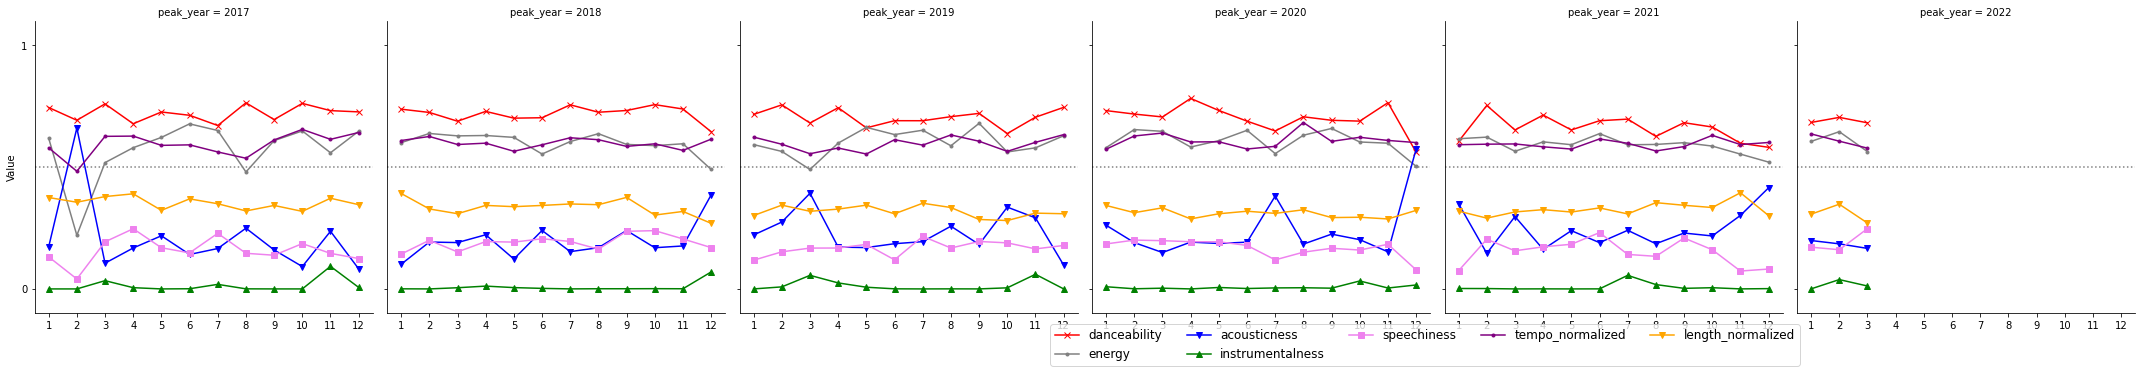

In [28]:
#graph out trends over the years 
plt.figure(figsize=(60,120))
grid = sns.FacetGrid(data=df_grpd_ym, col='peak_year', height=5)

grid.map(plt.axhline, y=0.5, ls=":", c=".5")

grid.map(plt.plot, "peak_month", "danceability", marker="x", color='r', label='danceability')
grid.map(plt.plot, "peak_month", "energy", marker=".", color='grey', label='energy')
grid.map(plt.plot, "peak_month", "acousticness", marker="v", color='b', label='acousticness')
grid.map(plt.plot, "peak_month", "instrumentalness", marker="^", color='g', label='instrumentalness')
grid.map(plt.plot, "peak_month", "speechiness", marker="s", color='violet', label='speechiness')
grid.map(plt.plot, "peak_month", "tempo_normalized", marker=".", color='purple', label='tempo_normalized')
grid.map(plt.plot, "peak_month", "length_normalized", marker="v", color='orange', label='length_normalized')

grid.set(xticks=np.arange(13), yticks=[0, 1], 
         xlim=(0.5,12.5), ylim=(-0.1,1.1), 
         ylabel='Value', xlabel='')

plt.legend(loc='lower center', bbox_to_anchor=(-1.1, -0.2), ncol=5, fontsize=12)

plt.show()

<Figure size 4320x8640 with 0 Axes>

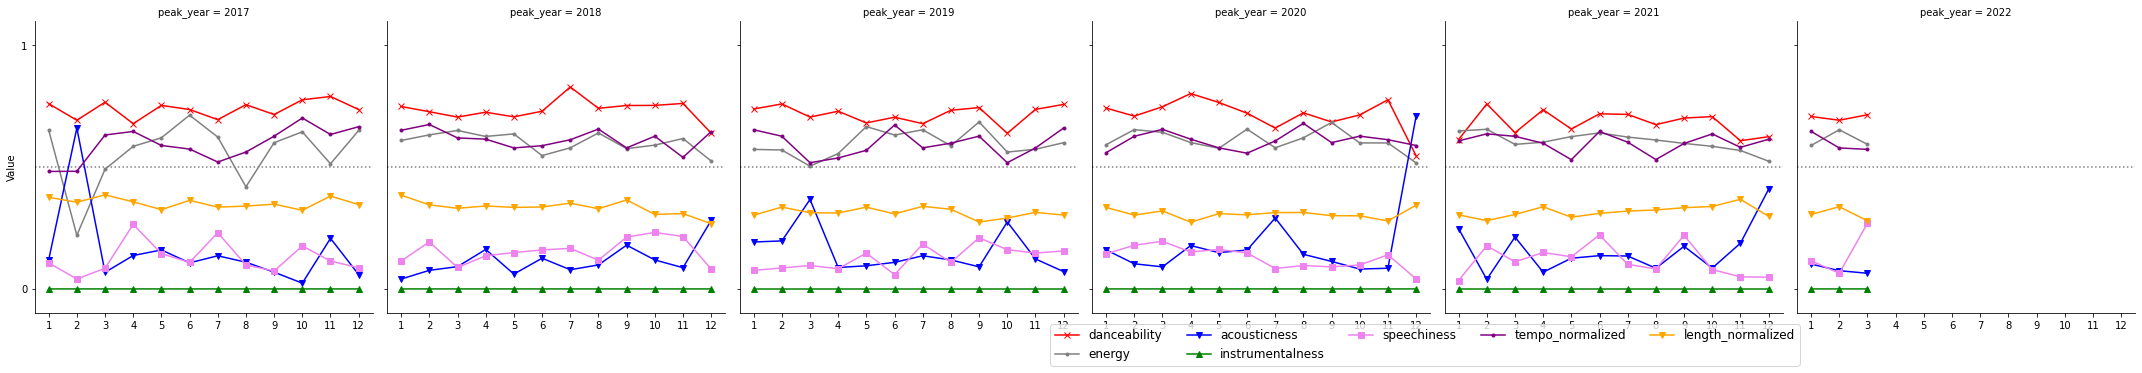

In [29]:
#group data by year/month with median data
df_grpd_ym = final_df.groupby(['peak_year','peak_month']).median().reset_index()
df_grpd_ym

#graph trends over the years
plt.figure(figsize=(60,120))
grid = sns.FacetGrid(data=df_grpd_ym, col='peak_year', height=5)

grid.map(plt.axhline, y=0.5, ls=":", c=".5")

grid.map(plt.plot, "peak_month", "danceability", marker="x", color='r', label='danceability')
grid.map(plt.plot, "peak_month", "energy", marker=".", color='grey', label='energy')
grid.map(plt.plot, "peak_month", "acousticness", marker="v", color='b', label='acousticness')
grid.map(plt.plot, "peak_month", "instrumentalness", marker="^", color='g', label='instrumentalness')
grid.map(plt.plot, "peak_month", "speechiness", marker="s", color='violet', label='speechiness')
grid.map(plt.plot, "peak_month", "tempo_normalized", marker=".", color='purple', label='tempo_normalized')
grid.map(plt.plot, "peak_month", "length_normalized", marker="v", color='orange', label='length_normalized')

grid.set(xticks=np.arange(13), yticks=[0, 1], 
         xlim=(0.5,12.5), ylim=(-0.1,1.1), 
         ylabel='Value', xlabel='')

plt.legend(loc='lower center', bbox_to_anchor=(-1.1, -0.2), ncol=5, fontsize=12)

plt.show()

In [30]:
#group data by year/month using mean data FILTERING for songs with over 100 mil streams
df_grpd_ym_100_mil = songs_over_100_mil.groupby(['peak_year','peak_month']).mean().reset_index()
df_grpd_ym_100_mil

"""
#graph data
plt.figure(figsize=(60,120))
grid = sns.FacetGrid(data=df_grpd_ym_100_mil, col='peak_year', height=5)

grid.map(plt.axhline, y=0.5, ls=":", c=".5")

grid.map(plt.plot, "peak_month", "danceability", marker="x", color='r', label='danceability')
grid.map(plt.plot, "peak_month", "energy", marker=".", color='grey', label='energy')
grid.map(plt.plot, "peak_month", "acousticness", marker="v", color='b', label='acousticness')
grid.map(plt.plot, "peak_month", "instrumentalness", marker="^", color='g', label='instrumentalness')
grid.map(plt.plot, "peak_month", "speechiness", marker="s", color='violet', label='speechiness')
grid.map(plt.plot, "peak_month", "tempo_normalized", marker=".", color='purple', label='tempo_normalized')
grid.map(plt.plot, "peak_month", "length_normalized", marker="v", color='orange', label='length_normalized')

grid.set(xticks=np.arange(13), yticks=[0, 1], 
         xlim=(0.5,12.5), ylim=(-0.1,1.1), 
         ylabel='Value', xlabel='')

plt.legend(loc='lower center', bbox_to_anchor=(-1.1, -0.2), ncol=5, fontsize=12)

plt.show()
"""

'\n#graph data\nplt.figure(figsize=(60,120))\ngrid = sns.FacetGrid(data=df_grpd_ym_100_mil, col=\'peak_year\', height=5)\n\ngrid.map(plt.axhline, y=0.5, ls=":", c=".5")\n\ngrid.map(plt.plot, "peak_month", "danceability", marker="x", color=\'r\', label=\'danceability\')\ngrid.map(plt.plot, "peak_month", "energy", marker=".", color=\'grey\', label=\'energy\')\ngrid.map(plt.plot, "peak_month", "acousticness", marker="v", color=\'b\', label=\'acousticness\')\ngrid.map(plt.plot, "peak_month", "instrumentalness", marker="^", color=\'g\', label=\'instrumentalness\')\ngrid.map(plt.plot, "peak_month", "speechiness", marker="s", color=\'violet\', label=\'speechiness\')\ngrid.map(plt.plot, "peak_month", "tempo_normalized", marker=".", color=\'purple\', label=\'tempo_normalized\')\ngrid.map(plt.plot, "peak_month", "length_normalized", marker="v", color=\'orange\', label=\'length_normalized\')\n\ngrid.set(xticks=np.arange(13), yticks=[0, 1], \n         xlim=(0.5,12.5), ylim=(-0.1,1.1), \n         y

<Figure size 4320x8640 with 0 Axes>

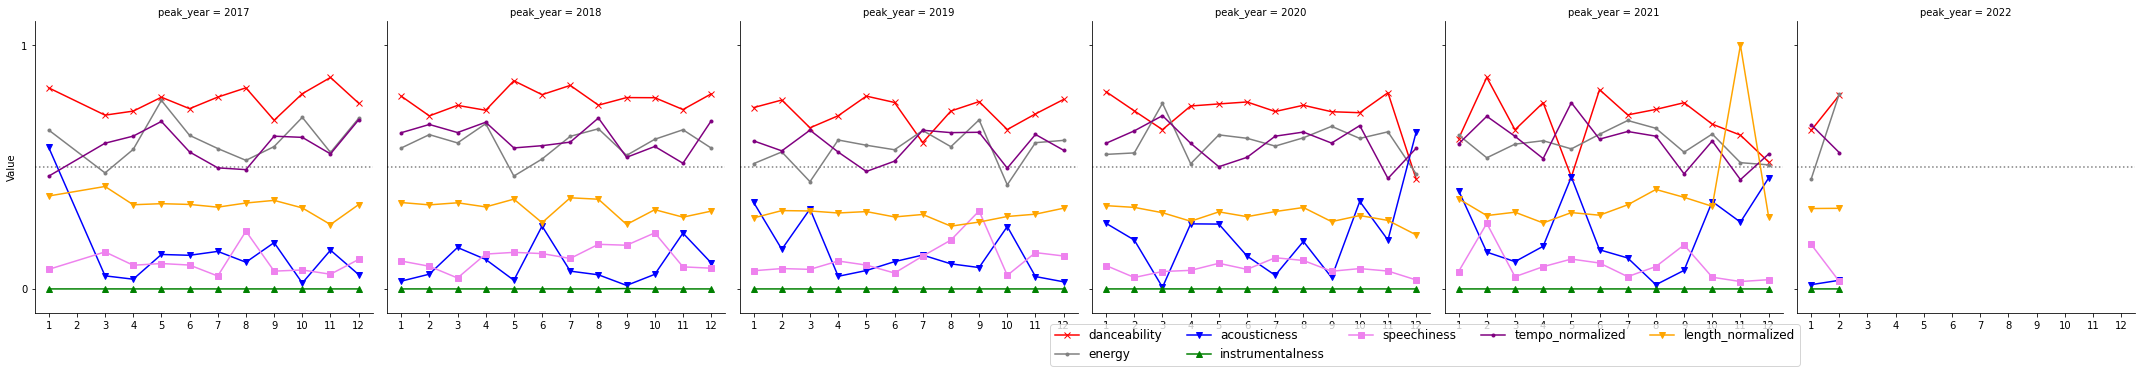

In [31]:
#group data by year/month using mean data FILTERING for songs with over 100 mil streams
df_grpd_ym = songs_over_100_mil.groupby(['peak_year','peak_month']).median().reset_index()
df_grpd_ym

#graph data
plt.figure(figsize=(60,120))
grid = sns.FacetGrid(data=df_grpd_ym, col='peak_year', height=5)

grid.map(plt.axhline, y=0.5, ls=":", c=".5")

grid.map(plt.plot, "peak_month", "danceability", marker="x", color='r', label='danceability')
grid.map(plt.plot, "peak_month", "energy", marker=".", color='grey', label='energy')
grid.map(plt.plot, "peak_month", "acousticness", marker="v", color='b', label='acousticness')
grid.map(plt.plot, "peak_month", "instrumentalness", marker="^", color='g', label='instrumentalness')
grid.map(plt.plot, "peak_month", "speechiness", marker="s", color='violet', label='speechiness')
grid.map(plt.plot, "peak_month", "tempo_normalized", marker=".", color='purple', label='tempo_normalized')
grid.map(plt.plot, "peak_month", "length_normalized", marker="v", color='orange', label='length_normalized')

grid.set(xticks=np.arange(13), yticks=[0, 1], 
         xlim=(0.5,12.5), ylim=(-0.1,1.1), 
         ylabel='Value', xlabel='')

plt.legend(loc='lower center', bbox_to_anchor=(-1.1, -0.2), ncol=5, fontsize=12)

plt.show()

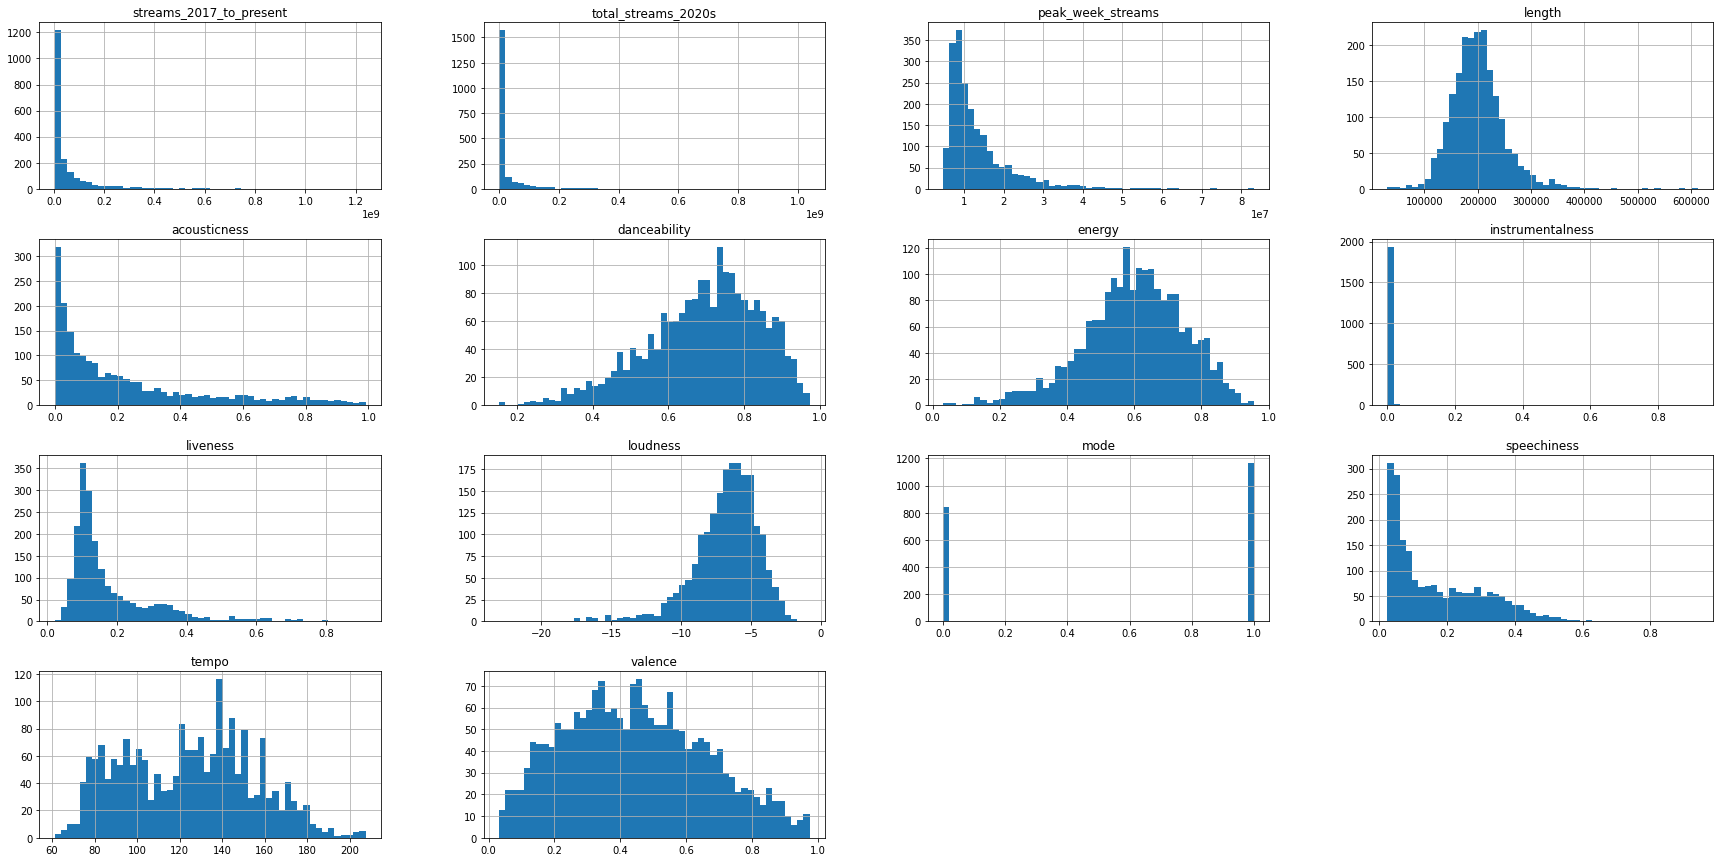

In [32]:
final_df[['streams_2017_to_present','total_streams_2020s'
          ,'peak_week_streams','length','acousticness'
         ,'danceability','energy','instrumentalness','liveness'
         ,'loudness','mode','speechiness','tempo'
          ,'valence']].hist(figsize=(30,15), bins=50)

plt.show()


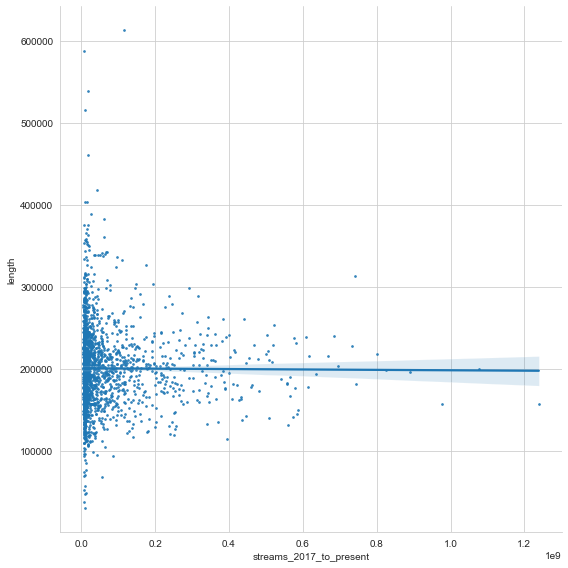

In [33]:
sns.set_style('whitegrid')
sns.lmplot('streams_2017_to_present','length', data=final_df
           , palette='coolwarm',size=8,aspect=1
           , scatter_kws={"s":3})